<a href="https://colab.research.google.com/github/TheBugBattler/Astrophysics/blob/main/Zoobot_Finetune_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import logging

logging.basicConfig(level=logging.INFO)

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Downloads a pretrained checkpoint
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [5]:
!git clone https://github.com/mwalmsley/zoobot.git # places the cloned repo into zoobot_dir

# there's an identical notebook I use for testing the pre-release versions of zoobot and galaxy-datasets here, if useful
# https://colab.research.google.com/drive/1A_-M3Sz5maQmyfW2A7rEu-g_Zi0RMGz5?usp=sharing

fatal: destination path 'zoobot' already exists and is not an empty directory.


In [3]:
!pip install -e /content/zoobot[pytorch_colab]

Obtaining file:///content/zoobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━



If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [6]:
# google colab needs this hack to make git-cloned packaged importable
# it's not needed locally
import os
import sys
zoobot_dir = '/content/zoobot'
os.chdir(zoobot_dir)
sys.path.append(zoobot_dir)
!git pull  # just to make sure we're up to date

Already up to date.


Now we're set up and can start using Zoobot.

## Download Pretrained Checkpoint

In [7]:


# make a directory to place the checkpoint
# this could be anywhere, but Zoobot has this folder already
checkpoint_dir = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch')  # Can place your checkpoint anywhere,

# if not os.path.isdir(checkpoint_dir):
#   os.makedirs(checkpoint_dir)

Download the pretrained model checkpoint from Dropbox.

The pretrained models are described and linked from the [Data Notes](https://zoobot.readthedocs.io/en/latest/data_notes.html) docs.

Outside Colab, you can just download them with a browser.
On Colab, we don't have a file browser, so we have will download them with this one-liner.

In [8]:
!wget --no-check-certificate 'https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0' -O $checkpoint_dir/checkpoint.ckpt

--2024-04-01 19:44:04--  https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.4.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17384753 (17M) [application/octet-stream]
Saving to: ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’

/content/zoobot/dat 100%[===================>]  16.58M  32.2MB/s    in 0.5s    

2024-04-01 19:44:06 (32.2 MB/s) - ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’ saved [17384753/17384753]



## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [9]:
# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import demo_rings

In [10]:
data_dir = os.path.join(zoobot_dir, 'data/demo_rings')

In [11]:
train_catalog, label_cols = demo_rings(root=data_dir, download=True, train=True)
test_catalog, _ = demo_rings(root=data_dir, download=True, train=False)

100%|██████████| 30797/30797 [00:00<00:00, 845410.63it/s]


100%|██████████| 10802/10802 [00:00<00:00, 11028936.66it/s]


100%|██████████| 43446358/43446358 [00:01<00:00, 37388772.85it/s]


Extracting /content/zoobot/data/demo_rings/demo_rings_images.tar.gz to /content/zoobot/data/demo_rings
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_train_catalog.parquet
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_test_catalog.parquet
Using downloaded and verified file: /content/zoobot/data/demo_rings/demo_rings_images.tar.gz
Extracting /content/zoobot/data/demo_rings/demo_rings_images.tar.gz to /content/zoobot/data/demo_rings


In [12]:
train_catalog.head()

,id_str,ring_fraction,subfolder,filename,ring,file_loc
0,487483_3522,0.714286,487483,487483_3522.jpg,True,/content/zoobot/data/demo_rings/images/487483/...
1,287521_2026,0.666667,287521,287521_2026.jpg,True,/content/zoobot/data/demo_rings/images/287521/...
2,519986_112,0.583333,519986,519986_112.jpg,True,/content/zoobot/data/demo_rings/images/519986/...
3,362959_3369,0.800000,362959,362959_3369.jpg,True,/content/zoobot/data/demo_rings/images/362959/...
4,426137_3385,0.700000,426137,426137_3385.jpg,True,/content/zoobot/data/demo_rings/images/426137/...


Wondering about "label_cols"?

This is a list of catalog columns which should be used as labels

Here,`label_cols = ['ring']`



For binary classification, the label column should have binary (0 or 1) labels for your classes.

To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.


## Configure Finetuning

In [13]:
import pandas as pd

from zoobot.pytorch.training import finetune
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [14]:
# TODO you can update these paths to suit own data
checkpoint_loc = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch/checkpoint.ckpt')  # downloaded above
save_dir = os.path.join(zoobot_dir, 'results/pytorch/finetune/finetune_binary_classification')

In [15]:
label_col = 'ring'  # name of column in catalog with binary (0 or 1) labels for your classes
label_cols = [label_col]  # To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.

In [16]:
train_catalog[label_col] = train_catalog[label_col].astype(int)

In [17]:
train_catalog[label_col]

0      1
1      1
2      1
3      1
4      1
      ..
795    0
796    1
797    0
798    1
799    0
Name: ring, Length: 800, dtype: int64

In [18]:
datamodule = GalaxyDataModule(
  label_cols=label_cols,
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2  # sets the parallelism for loading data. 2 works well on colab.
)

## Check Images Load

Optional - check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [19]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

# Now the Actual Finetuning

In [20]:
model = finetune.FinetuneableZoobotClassifier(
  checkpoint_loc=checkpoint_loc,
  num_classes=2,
  n_blocks=2  # only updating the head weights. Set 0 for only output layer. Set e.g. 1, 2 to finetune deeper.
)
# don't worry about any "automatically upgraded" INFO message below

In [21]:
trainer = finetune.get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=30)
trainer.fit(model, datamodule)
# should reach about 85% accuracy, loss of about 0.4

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | EfficientNet     | 4.0 M 
1 | train_loss_metric | MeanMetric       | 0     
2 | val_loss_metric   | MeanMetric       | 0     
3 | test_loss_metric  | MeanMetric       | 0     
4 | head              | LinearClassifier | 2.6 K 
5 | train_acc         | BinaryAccuracy   | 0     
6 | val_acc           | BinaryAccuracy   | 0     
7 | test_acc          | BinaryAccuracy   | 0     
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 17: 'finetuning/val_loss' reached 0.69405 (best 0.69405), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 34: 'finetuning/val_loss' reached 0.69309 (best 0.69309), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 51: 'finetuning/val_loss' reached 0.68850 (best 0.68850), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 68: 'finetuning/val_loss' reached 0.67980 (best 0.67980), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 85: 'finetuning/val_loss' reached 0.65104 (best 0.65104), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 102: 'finetuning/val_loss' reached 0.61634 (best 0.61634), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 119: 'finetuning/val_loss' reached 0.59161 (best 0.59161), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 136: 'finetuning/val_loss' reached 0.55420 (best 0.55420), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 153: 'finetuning/val_loss' reached 0.52661 (best 0.52661), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 170: 'finetuning/val_loss' reached 0.48252 (best 0.48252), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 187: 'finetuning/val_loss' reached 0.44209 (best 0.44209), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 204: 'finetuning/val_loss' reached 0.40953 (best 0.40953), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 221: 'finetuning/val_loss' reached 0.37934 (best 0.37934), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 238: 'finetuning/val_loss' reached 0.36052 (best 0.36052), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 255: 'finetuning/val_loss' reached 0.33722 (best 0.33722), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 272: 'finetuning/val_loss' reached 0.32168 (best 0.32168), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 289: 'finetuning/val_loss' reached 0.32150 (best 0.32150), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 306: 'finetuning/val_loss' reached 0.30287 (best 0.30287), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 323: 'finetuning/val_loss' reached 0.29626 (best 0.29626), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 340: 'finetuning/val_loss' reached 0.29523 (best 0.29523), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 357: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 374: 'finetuning/val_loss' reached 0.29137 (best 0.29137), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 391: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 408: 'finetuning/val_loss' reached 0.28795 (best 0.28795), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 425: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 442: 'finetuning/val_loss' reached 0.27936 (best 0.27936), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/25.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 459: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 476: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 493: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 510: 'finetuning/val_loss' reached 0.26290 (best 0.26290), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/29.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [22]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = finetune.FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [23]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  label_cols=['not_ring', 'ring'],  # it's a quick of the current code that it always makes 2D predictions. For binary, [no, yes]. I might change this.
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Let's quickly check if they're any good:

In [24]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,not_ring_pred,ring_pred
0,453526_3245,0.006878,0.993121
1,127202_5277,0.101156,0.898844
2,469597_327,0.955056,0.044944
3,433105_1762,0.989069,0.010931
4,52497_3109,0.239535,0.760465


In [25]:

predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'ring']])
predictions.head()

,id_str,not_ring_pred,ring_pred,file_loc,ring
0,453526_3245,0.006878,0.993121,/content/zoobot/data/demo_rings/images/453526/...,True
1,127202_5277,0.101156,0.898844,/content/zoobot/data/demo_rings/images/127202/...,True
2,469597_327,0.955056,0.044944,/content/zoobot/data/demo_rings/images/469597/...,False
3,433105_1762,0.989069,0.010931,/content/zoobot/data/demo_rings/images/433105/...,False
4,52497_3109,0.239535,0.760465,/content/zoobot/data/demo_rings/images/52497/5...,True


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['ring_pred']) == galaxy['ring']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['ring_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['ring']), color=color)

    axes[n].axis('off')

72     297531_4326
89     496174_1981
86      498880_985
114     320199_672
50     496393_4172
          ...     
94      494983_983
15     329088_5754
33     333252_2098
77     326911_5263
6        458851_85
Name: id_str, Length: 200, dtype: object


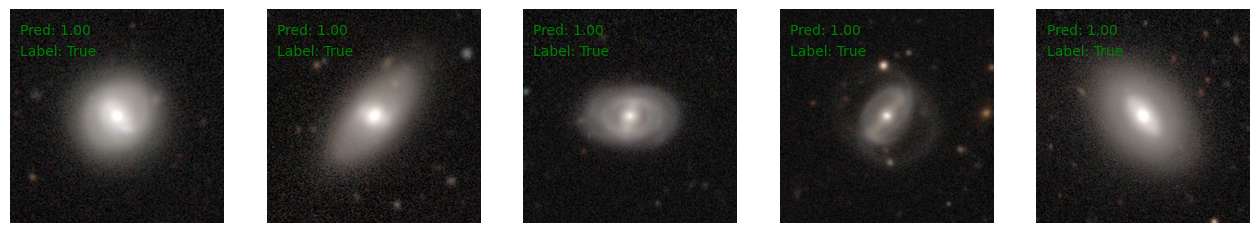

In [27]:
top_5_predictions = predictions.sort_values('ring_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

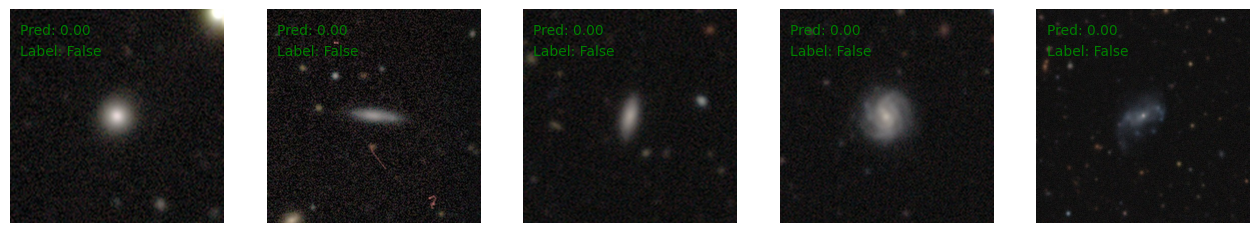

In [28]:
bottom_5_predictions = predictions.sort_values('ring_pred', ascending=True)
show_rings(bottom_5_predictions)

65     424255_1381
120    440062_1965
183    354313_2098
57     348565_3693
157    493765_2349
Name: id_str, dtype: object


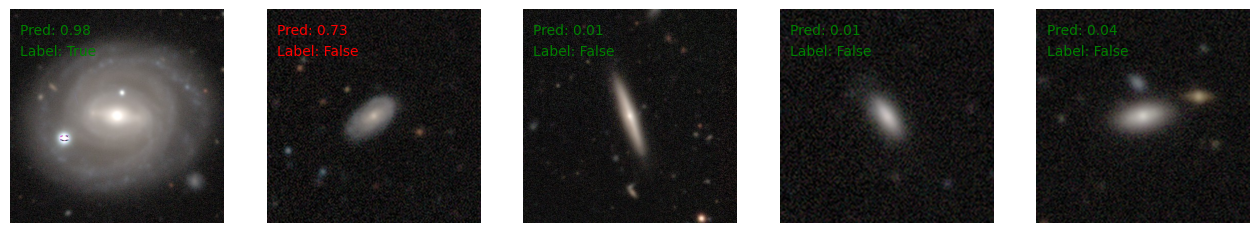

In [29]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

Pretty good given only a couple of hundred examples for each class.


In [30]:
train_catalog[label_col].value_counts()

0    427
1    373
Name: ring, dtype: int64